In [1]:
import os, json, sys, time, random
import numpy as np
import torch
from  easydict import EasyDict
from math import floor
from easydict import EasyDict

from steves_utils.vanilla_train_eval_test_jig import  Vanilla_Train_Eval_Test_Jig

from steves_utils.torch_utils import get_dataset_metrics, independent_accuracy_assesment
from steves_models.configurable_vanilla import Configurable_Vanilla
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.lazy_map import Lazy_Map
from steves_utils.sequence_aggregator import Sequence_Aggregator

from steves_utils.stratified_dataset.traditional_accessor import Traditional_Accessor_Factory

from steves_utils.cnn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.torch_utils import (
    confusion_by_domain_over_dataloader,
    independent_accuracy_assesment
)

from steves_utils.utils_v2 import (
    per_domain_accuracy_from_confusion,
    get_datasets_base_path
)

# from steves_utils.ptn_do_report import TBD

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "dataset_seed",
    "seed",
    "labels",
    "domains_target",
    "domains_source",
    "num_examples_per_domain_per_label_source",
    "num_examples_per_domain_per_label_target",
    "batch_size",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "normalize_source",
    "normalize_target",
    "x_net",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "pickle_name_source",
    "pickle_name_target",
    "torch_default_dtype",
}

In [3]:
from steves_utils.ORACLE.utils_v2 import (
    ALL_SERIAL_NUMBERS,
    ALL_DISTANCES_FEET_NARROWED,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "MANUAL CORES CNN"
standalone_parameters["lr"] = 0.0001
standalone_parameters["device"] = "cuda"

standalone_parameters["dataset_seed"] = 1337
standalone_parameters["seed"] = 1337
standalone_parameters["labels"] = ALL_SERIAL_NUMBERS

standalone_parameters["domains_source"] = [8,32,50]
standalone_parameters["domains_target"] = [14,20,26,38,44,]

standalone_parameters["num_examples_per_domain_per_label_source"]=-1
standalone_parameters["num_examples_per_domain_per_label_target"]=-1

standalone_parameters["pickle_name_source"] = "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"
standalone_parameters["pickle_name_target"] = "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"

standalone_parameters["torch_default_dtype"] = "torch.float32" 

standalone_parameters["batch_size"]=128

standalone_parameters["n_epoch"] = 3

standalone_parameters["patience"] = 10

standalone_parameters["criteria_for_best"] = "target_accuracy"
standalone_parameters["normalize_source"] = False
standalone_parameters["normalize_target"] = False

standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": len(standalone_parameters["labels"])}},
]

standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"

In [4]:
# Parameters
parameters = {
    "experiment_name": "cnn_2:oracle.run1_limited",
    "labels": [
        "3123D52",
        "3123D65",
        "3123D79",
        "3123D80",
        "3123D54",
        "3123D70",
        "3123D7B",
        "3123D89",
        "3123D58",
        "3123D76",
        "3123D7D",
        "3123EFE",
        "3123D64",
        "3123D78",
        "3123D7E",
        "3124E4A",
    ],
    "domains_source": [8, 32, 50, 14, 20, 26, 38, 44],
    "domains_target": [8, 32, 50, 14, 20, 26, 38, 44],
    "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl",
    "device": "cuda",
    "lr": 0.0001,
    "batch_size": 128,
    "normalize_source": False,
    "normalize_target": False,
    "num_examples_per_domain_per_label_source": 2000,
    "num_examples_per_domain_per_label_target": 2000,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 16}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "dataset_seed": 500,
    "seed": 500,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")



In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
def wrap_in_dataloader(p, ds):
    return torch.utils.data.DataLoader(
        ds,
        batch_size=p.batch_size,
        shuffle=True,
        num_workers=1,
        persistent_workers=True,
        prefetch_factor=50,
        pin_memory=True
    )

taf_source = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_source,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_source),
    seed=p.dataset_seed
)
train_original_source, val_original_source, test_original_source = \
    taf_source.get_train(), taf_source.get_val(), taf_source.get_test()


taf_target = Traditional_Accessor_Factory(
    labels=p.labels,
    domains=p.domains_target,
    num_examples_per_domain_per_label=p.num_examples_per_domain_per_label_source,
    pickle_path=os.path.join(get_datasets_base_path(), p.pickle_name_target),
    seed=p.dataset_seed
)
train_original_target, val_original_target, test_original_target = \
    taf_target.get_train(), taf_target.get_val(), taf_target.get_test()


# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Map. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[:2] # Strip the tuple to just (x,y)


train_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_source, transform_lambda)
)
val_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_source, transform_lambda)
)
test_processed_source = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_source, transform_lambda)
)

train_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(train_original_target, transform_lambda)
)
val_processed_target = wrap_in_dataloader(
    p,
    Lazy_Map(val_original_target, transform_lambda)
)
test_processed_target  = wrap_in_dataloader(
    p,
    Lazy_Map(test_original_target, transform_lambda)
)



datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [11]:
ep = next(iter(test_processed_target))
ep[0].dtype

torch.float32

In [12]:
model = Configurable_Vanilla(
    x_net=x_net,
    label_loss_object=torch.nn.NLLLoss(),
    learning_rate=p.lr
)

In [13]:
jig = Vanilla_Train_Eval_Test_Jig(
    model=model,
    path_to_best_model=p.BEST_MODEL_PATH,
    device=p.device,
    label_loss_object=torch.nn.NLLLoss(),
)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    patience=p.patience,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    criteria_for_best=p.criteria_for_best
)

epoch: 1, [batch: 1 / 1400], examples_per_second: 624.1165, train_label_loss: 2.7776, 


epoch: 1, [batch: 140 / 1400], examples_per_second: 11624.5341, train_label_loss: 2.7215, 


epoch: 1, [batch: 280 / 1400], examples_per_second: 11687.3239, train_label_loss: 2.6795, 


epoch: 1, [batch: 420 / 1400], examples_per_second: 11691.1087, train_label_loss: 2.6665, 


epoch: 1, [batch: 560 / 1400], examples_per_second: 11725.0987, train_label_loss: 2.6275, 


epoch: 1, [batch: 700 / 1400], examples_per_second: 11720.9883, train_label_loss: 2.6005, 


epoch: 1, [batch: 840 / 1400], examples_per_second: 11632.8953, train_label_loss: 2.5212, 


epoch: 1, [batch: 980 / 1400], examples_per_second: 11732.6577, train_label_loss: 2.5801, 


epoch: 1, [batch: 1120 / 1400], examples_per_second: 11638.6559, train_label_loss: 2.5713, 


epoch: 1, [batch: 1260 / 1400], examples_per_second: 11603.5880, train_label_loss: 2.5063, 


epoch: 1, source_val_acc_label: 0.1923, source_val_label_loss: 2.4778, target_val_acc_label: 0.1923, target_val_label_loss: 2.4778, 


New best
epoch: 2, [batch: 1 / 1400], examples_per_second: 54.7467, train_label_loss: 2.4195, 


epoch: 2, [batch: 140 / 1400], examples_per_second: 11644.0527, train_label_loss: 2.4267, 


epoch: 2, [batch: 280 / 1400], examples_per_second: 11650.8679, train_label_loss: 2.3998, 


epoch: 2, [batch: 420 / 1400], examples_per_second: 11553.7998, train_label_loss: 2.3703, 


epoch: 2, [batch: 560 / 1400], examples_per_second: 11684.9800, train_label_loss: 2.3649, 


epoch: 2, [batch: 700 / 1400], examples_per_second: 11641.3076, train_label_loss: 2.3984, 


epoch: 2, [batch: 840 / 1400], examples_per_second: 11628.7503, train_label_loss: 2.2763, 


epoch: 2, [batch: 980 / 1400], examples_per_second: 11514.3278, train_label_loss: 2.1837, 


epoch: 2, [batch: 1120 / 1400], examples_per_second: 11533.8522, train_label_loss: 2.0849, 


epoch: 2, [batch: 1260 / 1400], examples_per_second: 11584.8786, train_label_loss: 2.1081, 


epoch: 2, source_val_acc_label: 0.3022, source_val_label_loss: 2.0839, target_val_acc_label: 0.3022, target_val_label_loss: 2.0839, 


New best
epoch: 3, [batch: 1 / 1400], examples_per_second: 63.0261, train_label_loss: 1.9505, 


epoch: 3, [batch: 140 / 1400], examples_per_second: 11523.8132, train_label_loss: 1.8749, 


epoch: 3, [batch: 280 / 1400], examples_per_second: 11581.4156, train_label_loss: 1.8680, 


epoch: 3, [batch: 420 / 1400], examples_per_second: 11547.8053, train_label_loss: 1.8470, 


epoch: 3, [batch: 560 / 1400], examples_per_second: 11433.6682, train_label_loss: 1.9445, 


epoch: 3, [batch: 700 / 1400], examples_per_second: 11576.6243, train_label_loss: 1.8516, 


epoch: 3, [batch: 840 / 1400], examples_per_second: 11577.2074, train_label_loss: 2.0242, 


epoch: 3, [batch: 980 / 1400], examples_per_second: 11549.8229, train_label_loss: 1.9561, 


epoch: 3, [batch: 1120 / 1400], examples_per_second: 11694.5649, train_label_loss: 1.7177, 


epoch: 3, [batch: 1260 / 1400], examples_per_second: 11641.7006, train_label_loss: 1.6582, 


epoch: 3, source_val_acc_label: 0.4051, source_val_label_loss: 1.7225, target_val_acc_label: 0.4051, target_val_label_loss: 1.7225, 


New best
epoch: 4, [batch: 1 / 1400], examples_per_second: 62.9618, train_label_loss: 1.6219, 


epoch: 4, [batch: 140 / 1400], examples_per_second: 11540.6080, train_label_loss: 1.5317, 


epoch: 4, [batch: 280 / 1400], examples_per_second: 11607.4246, train_label_loss: 1.7919, 


epoch: 4, [batch: 420 / 1400], examples_per_second: 11723.7764, train_label_loss: 1.6723, 


epoch: 4, [batch: 560 / 1400], examples_per_second: 11672.1544, train_label_loss: 1.4848, 


epoch: 4, [batch: 700 / 1400], examples_per_second: 11684.5059, train_label_loss: 1.5181, 


epoch: 4, [batch: 840 / 1400], examples_per_second: 11690.1759, train_label_loss: 1.8614, 


epoch: 4, [batch: 980 / 1400], examples_per_second: 11729.4004, train_label_loss: 1.4907, 


epoch: 4, [batch: 1120 / 1400], examples_per_second: 11666.2283, train_label_loss: 1.3626, 


epoch: 4, [batch: 1260 / 1400], examples_per_second: 11681.0956, train_label_loss: 1.5490, 


epoch: 4, source_val_acc_label: 0.4738, source_val_label_loss: 1.5273, target_val_acc_label: 0.4738, target_val_label_loss: 1.5273, 


New best
epoch: 5, [batch: 1 / 1400], examples_per_second: 64.1978, train_label_loss: 1.2583, 


epoch: 5, [batch: 140 / 1400], examples_per_second: 11689.6175, train_label_loss: 1.2277, 


epoch: 5, [batch: 280 / 1400], examples_per_second: 11679.8304, train_label_loss: 1.2517, 


epoch: 5, [batch: 420 / 1400], examples_per_second: 11718.7223, train_label_loss: 1.1299, 


epoch: 5, [batch: 560 / 1400], examples_per_second: 11714.7771, train_label_loss: 1.1656, 


epoch: 5, [batch: 700 / 1400], examples_per_second: 11673.5231, train_label_loss: 1.1094, 


epoch: 5, [batch: 840 / 1400], examples_per_second: 11729.3785, train_label_loss: 1.3158, 


epoch: 5, [batch: 980 / 1400], examples_per_second: 11791.8561, train_label_loss: 1.2354, 


epoch: 5, [batch: 1120 / 1400], examples_per_second: 11692.3746, train_label_loss: 1.0057, 


epoch: 5, [batch: 1260 / 1400], examples_per_second: 11712.6394, train_label_loss: 1.1594, 


epoch: 5, source_val_acc_label: 0.5090, source_val_label_loss: 1.4099, target_val_acc_label: 0.5090, target_val_label_loss: 1.4099, 


New best
epoch: 6, [batch: 1 / 1400], examples_per_second: 66.6623, train_label_loss: 0.8952, 


epoch: 6, [batch: 140 / 1400], examples_per_second: 12530.3405, train_label_loss: 0.8701, 


epoch: 6, [batch: 280 / 1400], examples_per_second: 12451.1975, train_label_loss: 0.9851, 


epoch: 6, [batch: 420 / 1400], examples_per_second: 12421.8843, train_label_loss: 0.8326, 


epoch: 6, [batch: 560 / 1400], examples_per_second: 12631.5010, train_label_loss: 0.9058, 


epoch: 6, [batch: 700 / 1400], examples_per_second: 12588.8980, train_label_loss: 1.2640, 


epoch: 6, [batch: 840 / 1400], examples_per_second: 12611.0003, train_label_loss: 0.9513, 


epoch: 6, [batch: 980 / 1400], examples_per_second: 11080.4451, train_label_loss: 1.1482, 


epoch: 6, [batch: 1120 / 1400], examples_per_second: 10675.4973, train_label_loss: 0.8990, 


epoch: 6, [batch: 1260 / 1400], examples_per_second: 10687.9650, train_label_loss: 0.9525, 


epoch: 6, source_val_acc_label: 0.4913, source_val_label_loss: 1.4523, target_val_acc_label: 0.4913, target_val_label_loss: 1.4523, 


epoch: 7, [batch: 1 / 1400], examples_per_second: 57.8733, train_label_loss: 0.7645, 


epoch: 7, [batch: 140 / 1400], examples_per_second: 10603.1353, train_label_loss: 0.6868, 


epoch: 7, [batch: 280 / 1400], examples_per_second: 10568.9655, train_label_loss: 0.7816, 


epoch: 7, [batch: 420 / 1400], examples_per_second: 10671.6671, train_label_loss: 0.8248, 


epoch: 7, [batch: 560 / 1400], examples_per_second: 10687.2295, train_label_loss: 0.7449, 


epoch: 7, [batch: 700 / 1400], examples_per_second: 10690.2300, train_label_loss: 0.8037, 


epoch: 7, [batch: 840 / 1400], examples_per_second: 10711.2445, train_label_loss: 0.9505, 


epoch: 7, [batch: 980 / 1400], examples_per_second: 10721.2766, train_label_loss: 0.6748, 


epoch: 7, [batch: 1120 / 1400], examples_per_second: 10772.7668, train_label_loss: 0.7002, 


epoch: 7, [batch: 1260 / 1400], examples_per_second: 10698.4027, train_label_loss: 0.5930, 


epoch: 7, source_val_acc_label: 0.5002, source_val_label_loss: 1.4711, target_val_acc_label: 0.5002, target_val_label_loss: 1.4711, 


epoch: 8, [batch: 1 / 1400], examples_per_second: 57.4748, train_label_loss: 0.5667, 


epoch: 8, [batch: 140 / 1400], examples_per_second: 10626.8788, train_label_loss: 0.7900, 


epoch: 8, [batch: 280 / 1400], examples_per_second: 10651.7991, train_label_loss: 0.8238, 


epoch: 8, [batch: 420 / 1400], examples_per_second: 10710.3715, train_label_loss: 0.7644, 


epoch: 8, [batch: 560 / 1400], examples_per_second: 10728.6483, train_label_loss: 0.5562, 


epoch: 8, [batch: 700 / 1400], examples_per_second: 10693.6278, train_label_loss: 0.6020, 


epoch: 8, [batch: 840 / 1400], examples_per_second: 10737.5118, train_label_loss: 0.9834, 


epoch: 8, [batch: 980 / 1400], examples_per_second: 10669.9173, train_label_loss: 0.6382, 


epoch: 8, [batch: 1120 / 1400], examples_per_second: 10633.1556, train_label_loss: 0.5948, 


epoch: 8, [batch: 1260 / 1400], examples_per_second: 10673.1749, train_label_loss: 0.5462, 


epoch: 8, source_val_acc_label: 0.4738, source_val_label_loss: 1.5937, target_val_acc_label: 0.4738, target_val_label_loss: 1.5937, 


epoch: 9, [batch: 1 / 1400], examples_per_second: 57.1568, train_label_loss: 0.3582, 


epoch: 9, [batch: 140 / 1400], examples_per_second: 10587.1508, train_label_loss: 0.4140, 


epoch: 9, [batch: 280 / 1400], examples_per_second: 10696.1662, train_label_loss: 0.4500, 


epoch: 9, [batch: 420 / 1400], examples_per_second: 10683.4166, train_label_loss: 0.4437, 


epoch: 9, [batch: 560 / 1400], examples_per_second: 10666.0123, train_label_loss: 0.5036, 


epoch: 9, [batch: 700 / 1400], examples_per_second: 10697.4556, train_label_loss: 0.4541, 


epoch: 9, [batch: 840 / 1400], examples_per_second: 10765.6396, train_label_loss: 0.4573, 


epoch: 9, [batch: 980 / 1400], examples_per_second: 10674.6892, train_label_loss: 0.4225, 


epoch: 9, [batch: 1120 / 1400], examples_per_second: 10689.7420, train_label_loss: 0.5065, 


epoch: 9, [batch: 1260 / 1400], examples_per_second: 10717.4547, train_label_loss: 0.4134, 


epoch: 9, source_val_acc_label: 0.4917, source_val_label_loss: 1.6059, target_val_acc_label: 0.4917, target_val_label_loss: 1.6059, 


Patience (3) exhausted


In [14]:
total_experiment_time_secs = time.time() - start_time_secs

In [15]:
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = wrap_in_dataloader(p, Sequence_Aggregator((datasets.source.original.val, datasets.target.original.val)))

confusion = confusion_by_domain_over_dataloader(model, p.device, val_dl, forward_uses_domain=False)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

###################################
# Write out the results
###################################

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": p,
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "cnn"),
}

<AxesSubplot:title={'center':'Source Train Label Loss vs Source Val Label Loss'}, xlabel='Epoch'>

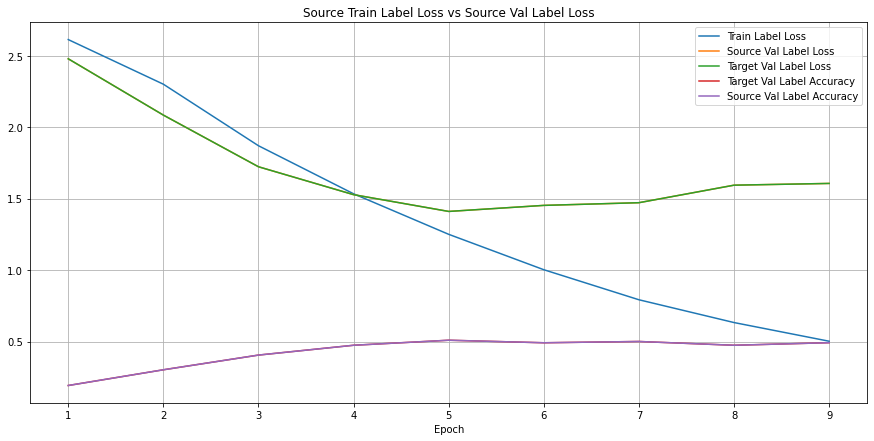

In [16]:
get_loss_curve(experiment)

<AxesSubplot:title={'center':'Results'}>

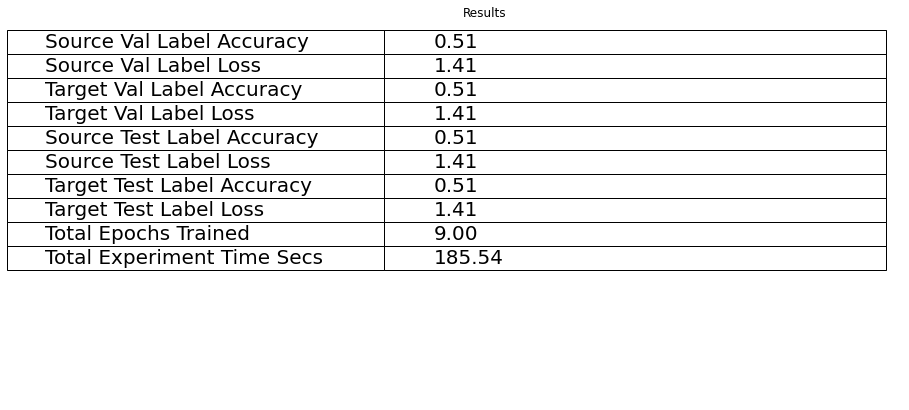

In [17]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Accuracy'}, xlabel='domain'>

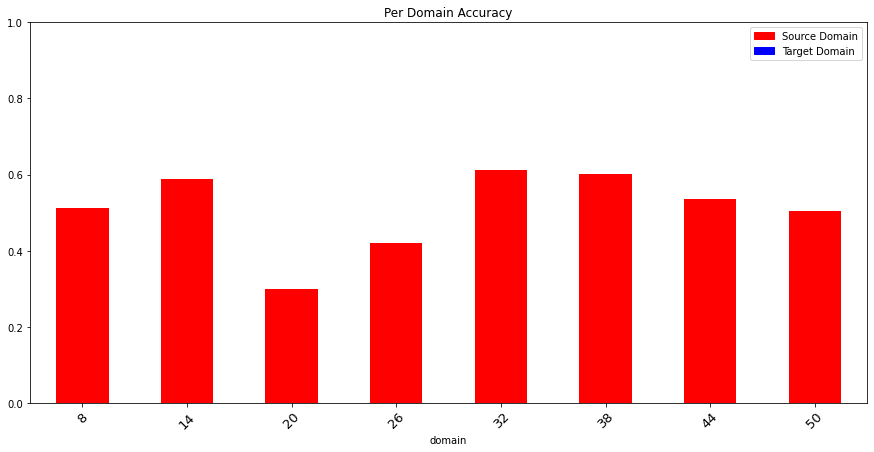

In [18]:
get_domain_accuracies(experiment)

In [19]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.5059895833333333 Target Test Label Accuracy: 0.5059895833333333
Source Val Label Accuracy: 0.508984375 Target Val Label Accuracy: 0.508984375


In [20]:
json.dumps(experiment)

'{"experiment_name": "cnn_2:oracle.run1_limited", "parameters": {"experiment_name": "cnn_2:oracle.run1_limited", "labels": ["3123D52", "3123D65", "3123D79", "3123D80", "3123D54", "3123D70", "3123D7B", "3123D89", "3123D58", "3123D76", "3123D7D", "3123EFE", "3123D64", "3123D78", "3123D7E", "3124E4A"], "domains_source": [8, 32, 50, 14, 20, 26, 38, 44], "domains_target": [8, 32, 50, 14, 20, 26, 38, 44], "pickle_name_source": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "pickle_name_target": "oracle.Run1_10kExamples_stratified_ds.2022A.pkl", "device": "cuda", "lr": 0.0001, "batch_size": 128, "normalize_source": false, "normalize_target": false, "num_examples_per_domain_per_label_source": 2000, "num_examples_per_domain_per_label_target": 2000, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 2